# Import necessary libraries

In [1]:
!pip install keras_tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 371.6 kB/s eta 0:00:00


In [2]:
# For data cleaning
!pip install pycountry-convert
import pycountry_convert as pc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.3/247.3 kB 6.4 MB/s eta 0:00:00


In [3]:
import math
import numpy as np
import pandas as pd
import calendar
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
import xgboost as xgb
from os.path import join
from matplotlib import pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn import ensemble, svm
from sklearn.metrics import classification_report, accuracy_score, precision_score
from tensorflow import keras
from scipy.stats import loguniform

# Used for Google Colab

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Get data

In [5]:
X_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/hotel_bookings_X_train.csv', sep=",")
y_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/hotel_bookings_Y_train.csv', sep=",").iloc[:, 0]
X_val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/hotel_bookings_X_val.csv', sep=",")
y_val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/hotel_bookings_Y_val.csv', sep=",").iloc[:, 0]
X_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/hotel_bookings_X_test.csv', sep=",")
y_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/hotel_bookings_Y_test.csv', sep=",").iloc[:, 0]

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(71632, 53)
(71632,)
(23878, 53)
(23878,)
(23878, 53)
(23878,)


# Feature Selection


Information Gain

In [8]:
info_gain = sorted(list(enumerate(mutual_info_classif(X_train, y_train, random_state = 0))), key=lambda x: x[1], reverse=True)

Variance Threshold

In [9]:
feature_variances = X_train.var()

In [11]:
# Initialize VarianceThreshold
selector = VarianceThreshold()

# Fit and transform the data
X_train_select = selector.fit_transform(X_train)

dropped_features = [column for column in X_train.columns if column not in X_train.columns[selector.get_support()]]

print("Dropped Features:", dropped_features)
print(X_train.shape)
print(X_train_select.shape)

Dropped Features: []
(71632, 53)
(71632, 53)


Decision Tree Classifier

In [12]:
# Train a Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=16, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
feat_importances = clf.feature_importances_
print(feat_importances)
print(X_train.columns[np.where(feat_importances <= 1e-4)])

[1.01534512e-01 2.03514424e-02 1.19872045e-02 1.59352105e-02
 6.02321932e-03 3.39102524e-03 4.84407521e-04 5.03386191e-02
 6.58260786e-03 1.75916185e-02 1.03284810e-03 5.56352003e-02
 3.06260752e-02 7.93772651e-02 7.28165314e-04 3.43547904e-03
 2.20085804e-03 5.83700451e-02 1.75381652e-03 2.38625322e-04
 2.15146326e-02 6.95248575e-03 0.00000000e+00 3.99164672e-01
 8.73901450e-05 1.31539705e-03 5.03092456e-04 8.95717968e-05
 1.17109568e-03 7.94298322e-05 9.02398955e-03 2.43120757e-03
 3.59572654e-04 3.66081160e-04 5.53107741e-04 5.14194311e-04
 2.39298255e-03 7.98774086e-04 5.85897530e-02 8.87897888e-05
 2.66492331e-03 2.41363728e-03 2.52138107e-03 1.49152501e-03
 2.08318420e-03 9.64151149e-04 0.00000000e+00 1.04743972e-03
 1.00354127e-02 8.18646461e-04 4.45721087e-04 1.23493803e-03
 6.64575126e-04]
Index(['deposit_type_no_deposit', 'deposit_type_refundable',
       'distribution_channel_gds', 'distribution_channel_undefined',
       'market_segment_undefined', 'continent_antarctica'],


Lasso Regression

In [13]:
lasso = Lasso()
params = {"alpha":[0.0001, 0.001, 0.01, 0.1]}
lasso_cv = GridSearchCV(lasso, param_grid=params, cv=5, scoring="neg_mean_squared_error")
lasso_cv.fit(X_train, y_train)
print("Best Params {}".format(lasso_cv.best_params_))

Best Params {'alpha': 0.0001}


In [14]:
lasso1 = Lasso(alpha=0.0001)
lasso1.fit(X_train, y_train)
lasso1_coef = np.abs(lasso1.coef_)

# Model exploration

In [ ]:
# indices_to_drop = [index for index, value in info_gain if value <= 1e-4]
# indices_to_drop = np.where(feature_variances <= 1e-4)
# indices_to_drop = np.where(feat_importances <= 1e-4)
# indices_to_drop = np.where(lasso1_coef <= 1e-4)
# columns_to_drop = X_train_scaled_df.columns[indices_to_drop]
# X_train_drop = X_train.drop(columns=columns_to_drop)
# X_val_drop = X_val.drop(columns=columns_to_drop)

# X_train_drop = X_train_scaled_df.drop(columns=columns_to_drop)
# X_val_drop = X_val_scaled_df.drop(columns=columns_to_drop)

In [ ]:
# X_train_drop = X_train_scaled_df
# X_val_drop = X_val_scaled_df

# Extra Trees

In [15]:
et_model = ensemble.ExtraTreesClassifier()
et_param = {
    'n_estimators': np.arange(10, 300, 50),
    'max_depth': np.arange(3, 10, 1),
    "max_features": np.arange(0.1, 0.75, 0.05),
    'criterion': ['entropy', 'gini'],
}
scoring = {'recall': 'recall', 'precision': 'precision', 'f1': 'f1', 'roc_auc': 'roc_auc'}
et_search = RandomizedSearchCV(
    estimator=et_model,
    param_distributions=et_param,
    n_iter=20,
    scoring=scoring,
    cv=5,
    random_state=0,
    n_jobs=-1,
    refit='precision',
)
et_fit = et_search.fit(X_train, y_train)

In [16]:
et_fit.best_params_

{'n_estimators': np.int64(110),
 'max_features': np.float64(0.15000000000000002),
 'max_depth': np.int64(7),
 'criterion': 'entropy'}

In [17]:
y_train_pred = et_fit.predict(X_train)
y_val_pred = et_fit.predict(X_val)
print(classification_report(y_train, y_train_pred))
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.72      1.00      0.84     45099
           1       1.00      0.33      0.50     26533

    accuracy                           0.75     71632
   macro avg       0.86      0.66      0.67     71632
weighted avg       0.82      0.75      0.71     71632

              precision    recall  f1-score   support

           0       0.72      1.00      0.83     15033
           1       1.00      0.33      0.49      8845

    accuracy                           0.75     23878
   macro avg       0.86      0.66      0.66     23878
weighted avg       0.82      0.75      0.71     23878



# XGBoost

In [18]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, booster='gbtree', objective='binary:logistic', eval_metric='logloss')
xgb_param = {
    'n_estimators': np.arange(50, 400, 50),
    'max_depth': np.arange(3, 10, 1),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'scale_pos_weight': [1, (y_train == 0).sum() / (y_train == 1).sum()],
    'gamma': [0, 0.1, 0.2, 0.4],
}
scoring = {'recall': 'recall', 'precision': 'precision', 'f1': 'f1', 'roc_auc': 'roc_auc'}
xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param,
    scoring=scoring,
    n_jobs=-1,
    refit='precision',
    random_state=0,
)
xgb_fit = xgb_search.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

[0]	validation_0-logloss:0.63911	validation_1-logloss:0.63904
[1]	validation_0-logloss:0.62527	validation_1-logloss:0.62521
[2]	validation_0-logloss:0.61279	validation_1-logloss:0.61270
[3]	validation_0-logloss:0.60111	validation_1-logloss:0.60112


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [01:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[4]	validation_0-logloss:0.58903	validation_1-logloss:0.58915
[5]	validation_0-logloss:0.57651	validation_1-logloss:0.57661
[6]	validation_0-logloss:0.56516	validation_1-logloss:0.56535
[7]	validation_0-logloss:0.55431	validation_1-logloss:0.55445
[8]	validation_0-logloss:0.54630	validation_1-logloss:0.54666
[9]	validation_0-logloss:0.53614	validation_1-logloss:0.53653
[10]	validation_0-logloss:0.52815	validation_1-logloss:0.52848
[11]	validation_0-logloss:0.52014	validation_1-logloss:0.52040
[12]	validation_0-logloss:0.51281	validation_1-logloss:0.51304
[13]	validation_0-logloss:0.50445	validation_1-logloss:0.50475
[14]	validation_0-logloss:0.49718	validation_1-logloss:0.49751
[15]	validation_0-logloss:0.49266	validation_1-logloss:0.49298
[16]	validation_0-logloss:0.48686	validation_1-logloss:0.48725
[17]	validation_0-logloss:0.48169	validation_1-logloss:0.48209
[18]	validation_0-logloss:0.47673	validation_1-logloss:0.47722
[19]	validation_0-logloss:0.47134	validation_1-logloss:0.4717

In [19]:
xgb_fit_best = xgb_search.best_estimator_
print(xgb_fit_best)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=np.int64(7), max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=np.int64(50), n_jobs=None,
              num_parallel_tree=None, ...)


In [20]:
y_train_pred = xgb_fit_best.predict(X_train)
y_val_pred = xgb_fit_best.predict(X_val)
print(classification_report(y_train, y_train_pred))
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87     45099
           1       0.87      0.62      0.72     26533

    accuracy                           0.82     71632
   macro avg       0.84      0.78      0.80     71632
weighted avg       0.83      0.82      0.82     71632

              precision    recall  f1-score   support

           0       0.81      0.95      0.87     15033
           1       0.87      0.62      0.72      8845

    accuracy                           0.82     23878
   macro avg       0.84      0.78      0.80     23878
weighted avg       0.83      0.82      0.82     23878



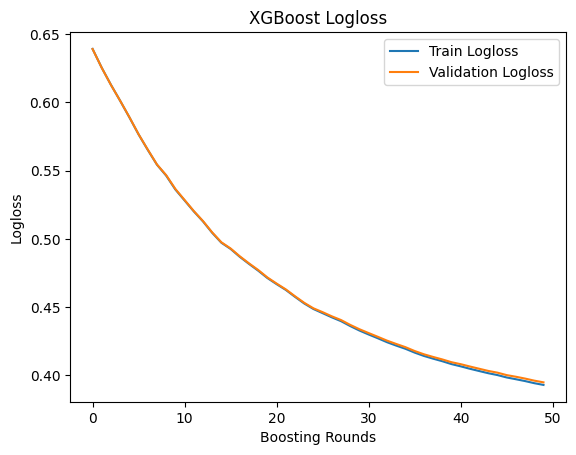

In [21]:
evals_result = xgb_fit_best.evals_result()
epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(epochs)
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Train Logloss')
plt.plot(x_axis, evals_result['validation_1']['logloss'], label='Validation Logloss')
plt.title('XGBoost Logloss')
plt.ylabel('Logloss')
plt.xlabel('Boosting Rounds')
plt.legend()

# Support Vector Machine

In [22]:
svm_model = svm.SVC(max_iter=1000, probability=True, class_weight='balanced', random_state=0)
params = {'C': loguniform(1e-3, 1e0), 'gamma': loguniform(1e-3, 1e0), 'kernel': ['linear', 'rbf']}
scoring = {'recall': 'recall', 'precision': 'precision', 'f1': 'f1', 'roc_auc': 'roc_auc'}
svm_search = RandomizedSearchCV(svm_model, params, scoring=scoring, return_train_score=True, refit='precision', random_state=0)
svm_fit = svm_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider

In [23]:
svm_fit_best = svm_search.best_estimator_
y_train_pred = svm_fit_best.predict(X_train)
y_val_pred = svm_fit_best.predict(X_val)
print(classification_report(y_train, y_train_pred))
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.93      0.19      0.31     45099
           1       0.41      0.98      0.58     26533

    accuracy                           0.48     71632
   macro avg       0.67      0.58      0.45     71632
weighted avg       0.74      0.48      0.41     71632

              precision    recall  f1-score   support

           0       0.93      0.19      0.32     15033
           1       0.41      0.98      0.58      8845

    accuracy                           0.48     23878
   macro avg       0.67      0.58      0.45     23878
weighted avg       0.74      0.48      0.41     23878



# Random Forest

In [24]:
rf_model = ensemble.RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=0)
param_rf = {
    "n_estimators": np.arange(1, 300, 10),
    "max_depth": np.arange(1, min(50, X_train.shape[0]), 2),
    "max_features": np.arange(0.1, 0.75, 0.05),
    }
scoring = {'recall': 'recall', 'precision': 'precision', 'f1': 'f1', 'roc_auc': 'roc_auc'}
rf_clf = RandomizedSearchCV(rf_model, param_rf, scoring=scoring, return_train_score=True, refit='precision', random_state=0)
rf_fit = rf_clf.fit(X_train, y_train)

In [25]:
rf_fit.best_params_

{'n_estimators': np.int64(241),
 'max_features': np.float64(0.25000000000000006),
 'max_depth': np.int64(35)}

In [26]:
# with standard scaler
y_train_pred = rf_fit.predict(X_train)
y_val_pred = rf_fit.predict(X_val)
print(classification_report(y_train, y_train_pred))
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     45099
           1       0.99      0.99      0.99     26533

    accuracy                           0.99     71632
   macro avg       0.99      0.99      0.99     71632
weighted avg       0.99      0.99      0.99     71632

              precision    recall  f1-score   support

           0       0.87      0.92      0.90     15033
           1       0.85      0.77      0.81      8845

    accuracy                           0.87     23878
   macro avg       0.86      0.85      0.85     23878
weighted avg       0.87      0.87      0.87     23878



In [27]:
y_test_pred = rf_fit.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90     15033
           1       0.85      0.77      0.81      8845

    accuracy                           0.86     23878
   macro avg       0.86      0.84      0.85     23878
weighted avg       0.86      0.86      0.86     23878



# Logistic regression

In [28]:
def build_model_tuner(hp, num_features, learning_rate):
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)
  np.random.seed(0)

  model = tf.keras.Sequential([tf.keras.layers.Input(shape=[num_features])])

  # L2 penalty
  l2_reg_strength = hp.Float('l2_regularizer',
                                min_value=1e-5,
                                max_value=1e-2,
                                sampling='log',
                                default=1e-4)

  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim
      use_bias=True,               # use a bias (intercept) param
      activation='sigmoid',
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
      kernel_regularizer=keras.regularizers.l2(l2_reg_strength),
  ))

  # Set up learning rate for optimizer and use SGD
  hp_lr = hp.Choice('learning_rate', values=learning_rate)
  optimizer = tf.keras.optimizers.SGD(learning_rate=hp_lr)

  # Finally, compile the model. This finalizes the graph for training.
  model.compile(
      optimizer=optimizer,
      loss=keras.losses.BinaryCrossentropy(),
      metrics=[
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Precision(thresholds=0),
        keras.metrics.F1Score(threshold=0.5),
    ],
  )

  return model

In [ ]:
!rm -r my_dir

In [29]:
# Set up Keras Tuner
num_epochs = 30
batch_size = 32
hp = kt.HyperParameters()
learning_rate = [0.0001, 0.001, 0.01]
tuner = kt.Hyperband(lambda hp: build_model_tuner(hp=hp, num_features=X_train.shape[1], learning_rate=learning_rate),
                     objective='val_loss',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
tuner.search(x=X_train, y=y_train, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[stop_early])
best_hp_results = tuner.get_best_hyperparameters()[0]

Trial 30 Complete [00h 03m 03s]
val_loss: 0.4509734511375427

Best val_loss So Far: 0.41165897250175476
Total elapsed time: 00h 32m 59s


In [30]:
best_hp_results.values

{'l2_regularizer': 1.6385471070412922e-05,
 'learning_rate': 0.01,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0012'}

In [31]:
log_model = tuner.hypermodel.build(best_hp_results)
log_model_tf = log_model.fit(
                        X_train,
                        y_train,
                        epochs=20,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        verbose=0)

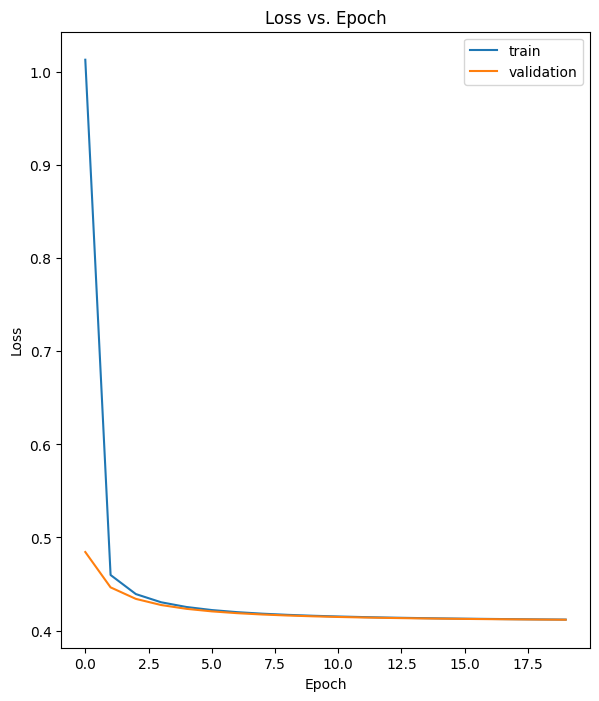

In [32]:
log_history = log_model_tf.history

# Plot loss and epoch of the best model
plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.plot(log_history['loss'], label='train')
plt.plot(log_history['val_loss'], label='validation')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [33]:
y_train_prob = log_model.predict(X_train)
y_train_pred = (y_train_prob > 0.5).astype(int)
train_metric = precision_score(y_train, y_train_pred)
y_val_prob = log_model.predict(X_val)
y_val_pred = (y_val_prob > 0.5).astype(int)
val_metric = precision_score(y_val, y_val_pred)
print(classification_report(y_train, y_train_pred))
print(classification_report(y_val, y_val_pred))

2239/2239 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0       0.81      0.92      0.86     45099
           1       0.82      0.64      0.72     26533

    accuracy                           0.82     71632
   macro avg       0.82      0.78      0.79     71632
weighted avg       0.82      0.82      0.81     71632

              precision    recall  f1-score   support

           0       0.82      0.91      0.86     15033
           1       0.82      0.65      0.72      8845

    accuracy                           0.82     23878
   macro avg       0.82      0.78      0.79     23878
weighted avg       0.82      0.82      0.81     23878



# Final Data Processing (submitted)

In [ ]:
X_train = pd.read_csv(path + 'hotel_bookings_X_train.csv', sep=",")
X_val = pd.read_csv(path + 'hotel_bookings_X_val.csv', sep=",")
X_test = pd.read_csv(path + 'hotel_bookings_X_test.csv', sep=",")

In [ ]:
X_train['adr'] = np.log1p(X_train['adr'])
X_train['lead_time'] = np.log1p(X_train['lead_time'])
X_train['days_in_waiting_list'] = np.log1p(X_train['days_in_waiting_list'])

X_val['adr'] = np.log1p(X_val['adr'])
X_val['lead_time'] = np.log1p(X_val['lead_time'])
X_val['days_in_waiting_list'] = np.log1p(X_val['days_in_waiting_list'])

X_test['adr'] = np.log1p(X_test['adr'])
X_test['lead_time'] = np.log1p(X_test['lead_time'])
X_test['days_in_waiting_list'] = np.log1p(X_test['days_in_waiting_list'])

In [ ]:
ohe_bin_prefixes = ['customer_type',
                    'deposit_type',
                    'distribution_channel',
                    'hotel',
                    'market_segment',
                    'meal',
                    'continent',
                    'is_reserved_room_type',
                    'is_repeated_guest',
                    'agent',
                    'company',]
ohe_bin_columns = [col for col in X_train.columns if any(col.startswith(p) for p in ohe_bin_prefixes)]
numerical_cols = X_train.drop(ohe_bin_columns, axis=1).columns
processor = ColumnTransformer(
    transformers = [
        ("num", StandardScaler(), numerical_cols),
        ("onehot", 'passthrough', ohe_bin_columns),
    ],
    remainder='passthrough'
)
processor.set_output(transform="pandas")
processor.fit(X_train)
X_train = processor.transform(X_train)
X_train.columns = X_train.columns.map(lambda x: x.split('__')[-1])

X_val = processor.transform(X_val)
X_val.columns = X_val.columns.map(lambda x: x.split('__')[-1])

X_test = processor.transform(X_test)
X_test.columns = X_test.columns.map(lambda x: x.split('__')[-1])

In [ ]:
X_train.to_csv(path + 'hotel_bookings_X_train.csv', index=False)
X_val.to_csv(path + 'hotel_bookings_X_val.csv', index=False)
X_test.to_csv(path + 'hotel_bookings_X_test.csv', index=False)

# Data Processing

In [ ]:
X_train['adr'] = np.log1p(X_train['adr'])
X_train['lead_time'] = np.log1p(X_train['lead_time'])
X_train['days_in_waiting_list'] = np.log1p(X_train['days_in_waiting_list'])

X_val['adr'] = np.log1p(X_val['adr'])
X_val['lead_time'] = np.log1p(X_val['lead_time'])
X_val['days_in_waiting_list'] = np.log1p(X_val['days_in_waiting_list'])

X_test['adr'] = np.log1p(X_test['adr'])
X_test['lead_time'] = np.log1p(X_test['lead_time'])
X_test['days_in_waiting_list'] = np.log1p(X_test['days_in_waiting_list'])

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

X_val_scaled = scaler.transform(X_val)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)

X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Feature Selection Analysis

Information Gain

In [34]:
for feature in info_gain[:5]:
  index, value = feature
  print(f"{X_train.columns[index]}: {value:0.6f}")
print('-----------------------')
zero_elements = [(index, value) for index, value in info_gain if value <= 1e-4]
for feature in zero_elements:
  index, value = feature
  print(f"{X_train.columns[index]}: {value}")

deposit_type_no_deposit: 0.136079
deposit_type_non_refund: 0.132263
lead_time: 0.081123
adr: 0.075095
is_reserved_room_type: 0.044705
-----------------------
customer_type_contract: 0.0
customer_type_group: 0.0
deposit_type_refundable: 0.0
distribution_channel_undefined: 0.0
market_segment_aviation: 0.0
market_segment_undefined: 0.0
continent_antarctica: 0.0
continent_unspecified: 0.0


Variance Threshold

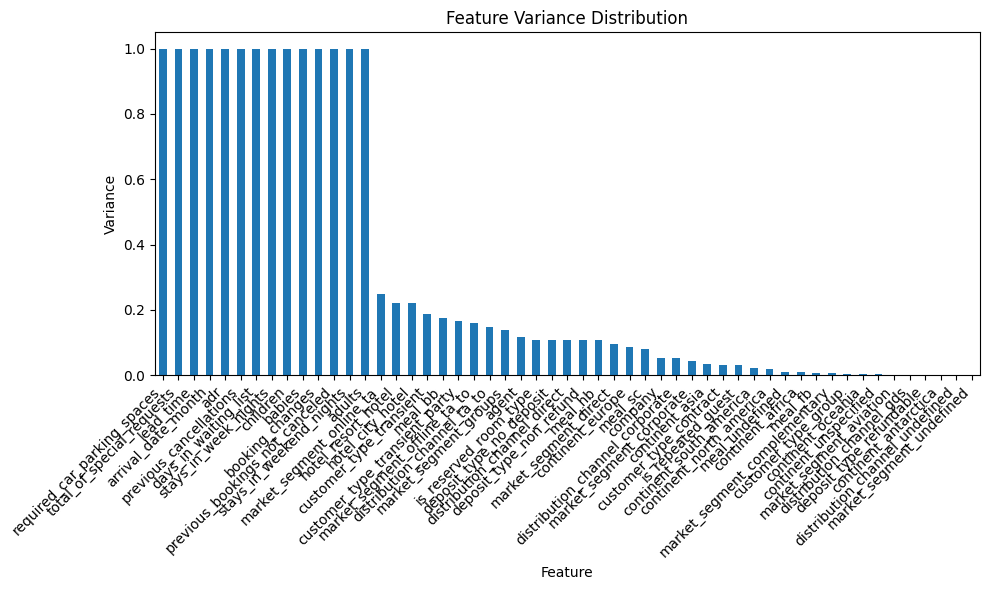

In [35]:
plt.figure(figsize=(10, 6))

feature_variances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Variance Distribution')
plt.xlabel('Feature')
plt.ylabel('Variance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [36]:
feature_variances[feature_variances <= 1e-4]

,0
distribution_channel_undefined,0.000028
market_segment_undefined,0.000014
continent_antarctica,0.000028


Lasso regression

In [38]:
lasso_plot = pd.Series(lasso1_coef, index=X_train.columns)
lasso_plot_sorted = lasso_plot.sort_values(key=np.abs, ascending=False)

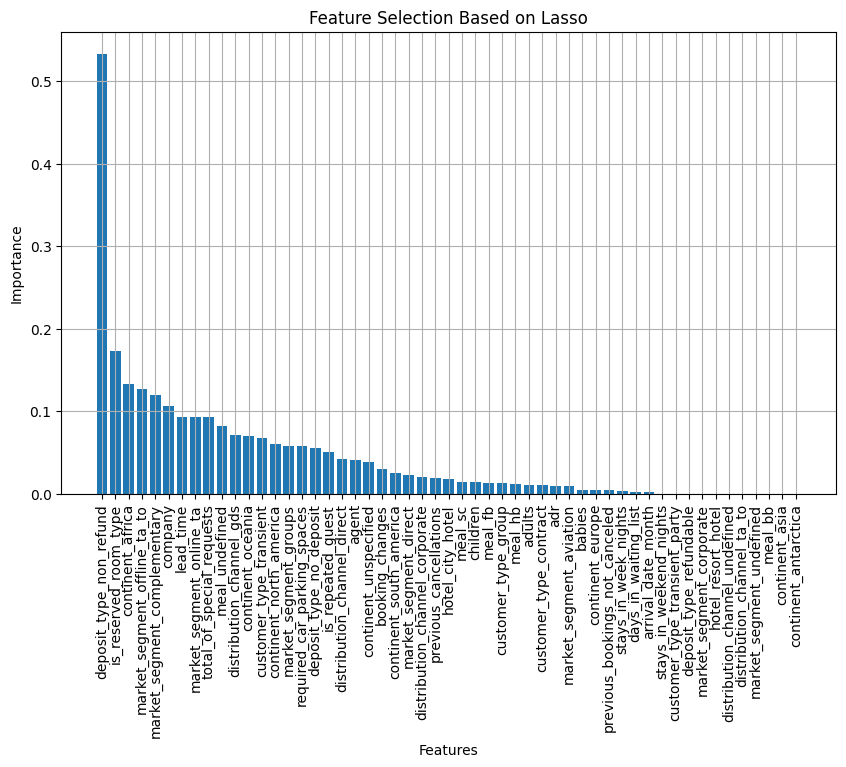

In [39]:
# Plot results of Lasso Regression
plt.figure(figsize=(10,6))
plt.bar(x=lasso_plot_sorted.index, height=lasso_plot_sorted.values)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0)
plt.show()

In [40]:
X_train.columns[np.where(lasso1_coef <= 1e-4)]

Index(['customer_type_transient_party', 'deposit_type_refundable',
       'distribution_channel_ta_to', 'distribution_channel_undefined',
       'hotel_resort_hotel', 'market_segment_corporate',
       'market_segment_undefined', 'meal_bb', 'continent_antarctica',
       'continent_asia'],
      dtype='object')

# Exploratory data analysis

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/hotel_bookings_processed.csv', sep=",")

In [ ]:
df['adr'] = np.log1p(df['adr'])
df['lead_time'] = np.log1p(df['lead_time'])
df['days_in_waiting_list'] = np.log1p(df['days_in_waiting_list'])

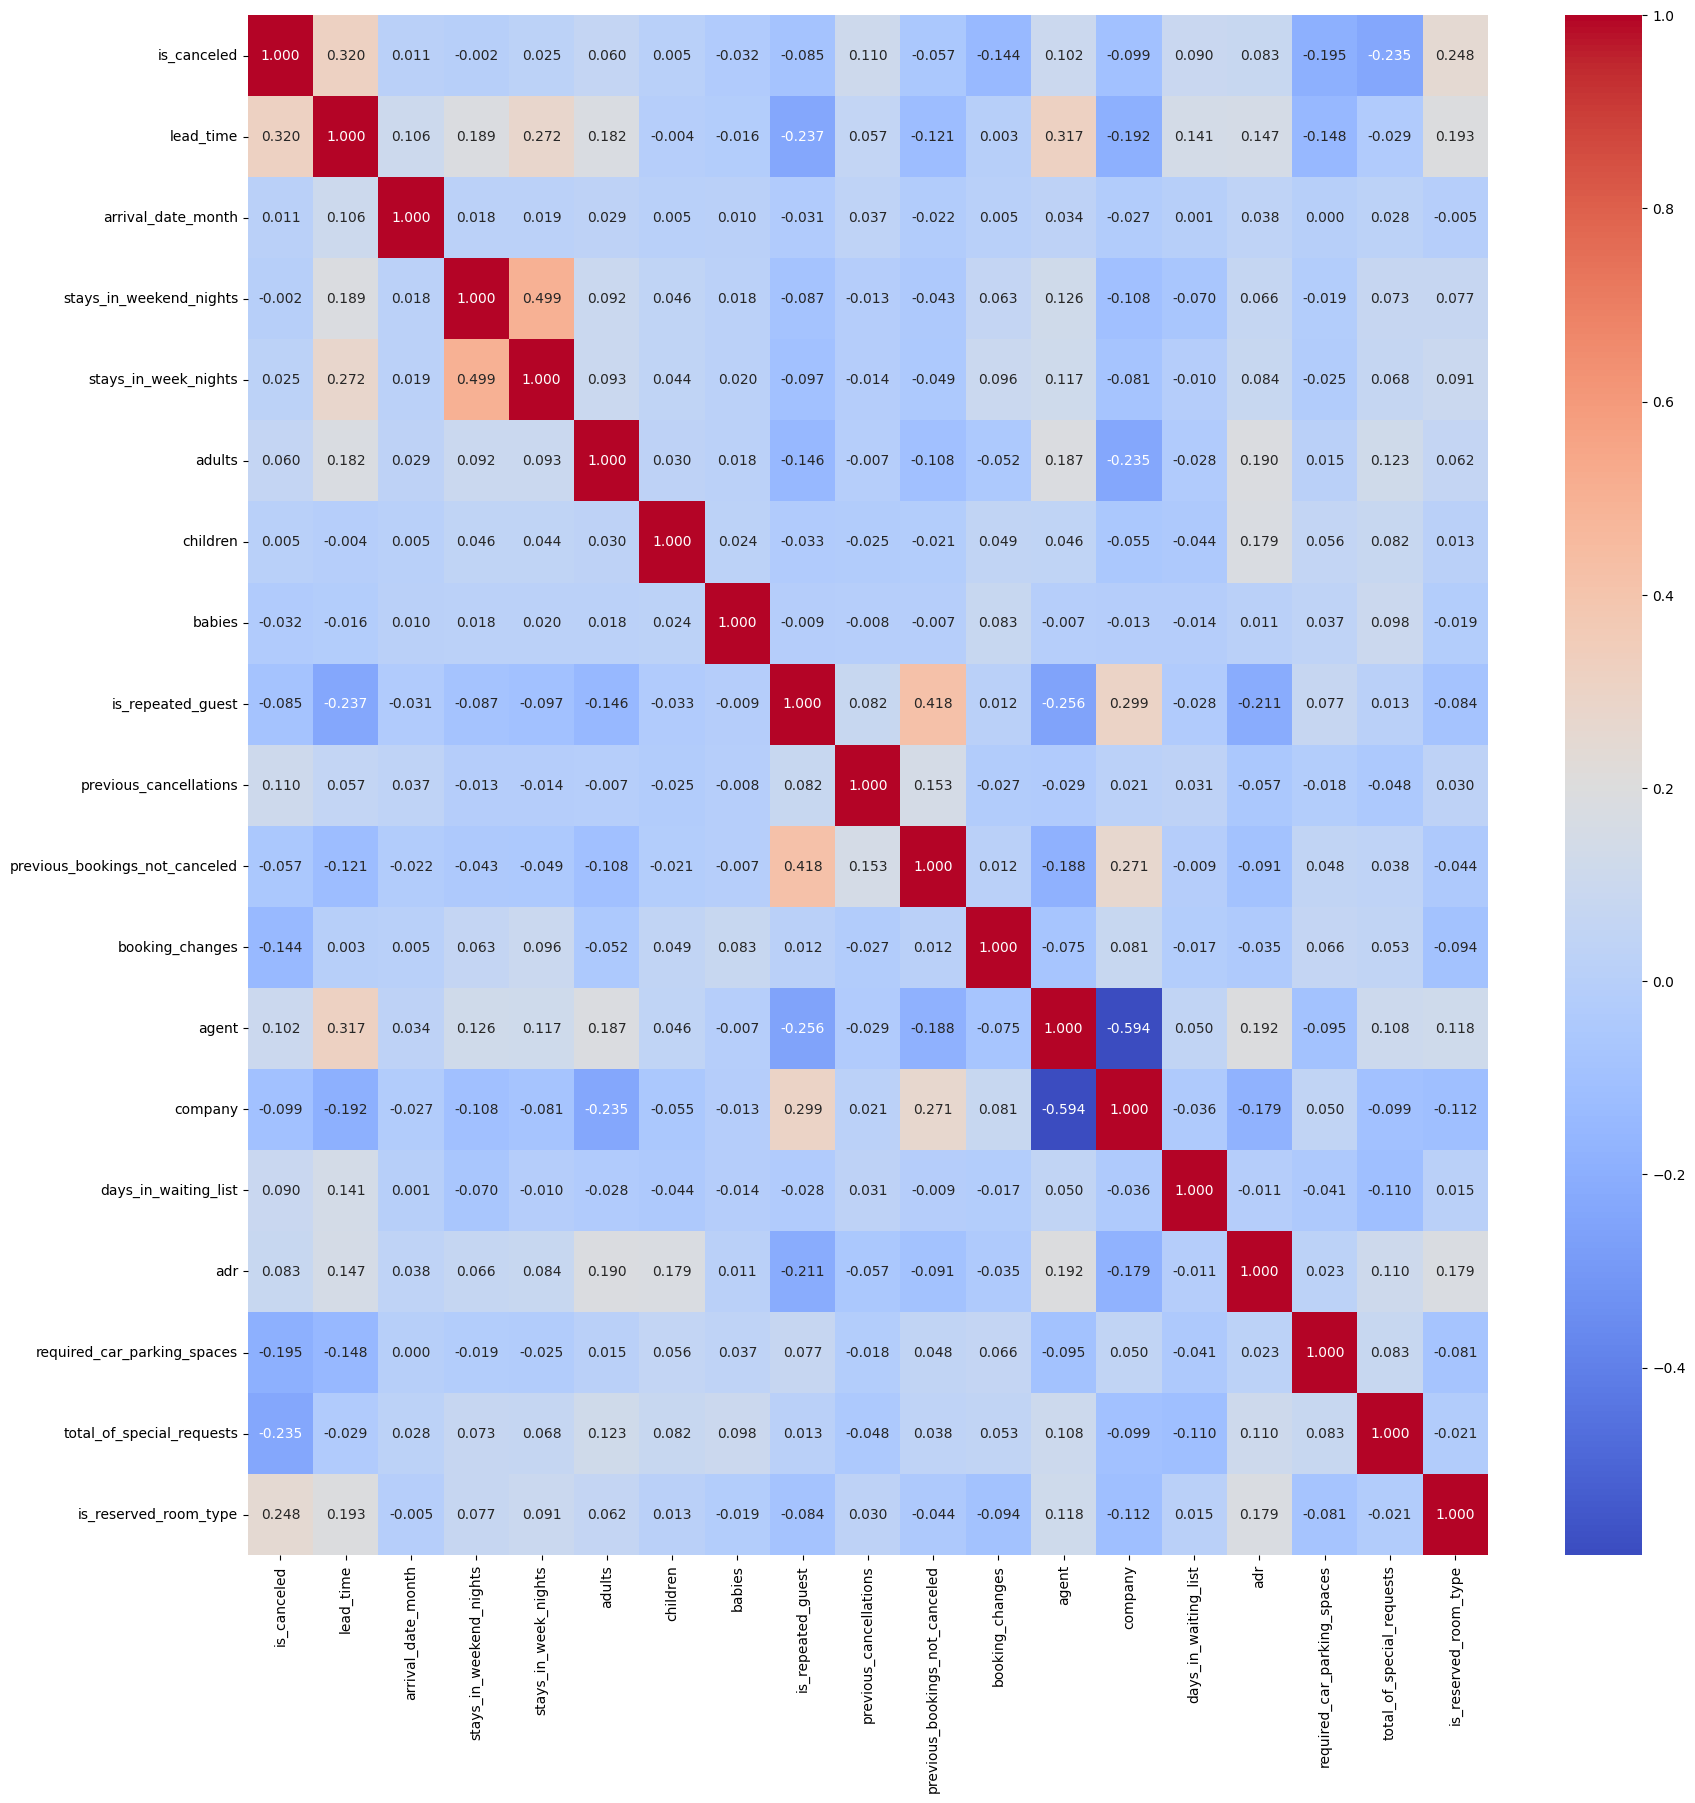

In [ ]:
regexes = ['customer_type', 'deposit_type', 'distribution_channel', 'market_segment', 'meal', 'hotel', 'continent']
cols_to_drop = df.filter(regex='|'.join(regexes)).columns
df_corr = df.drop(cols_to_drop, axis=1)

plt.figure(figsize=(20, 20))
hm = sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt='.3f')

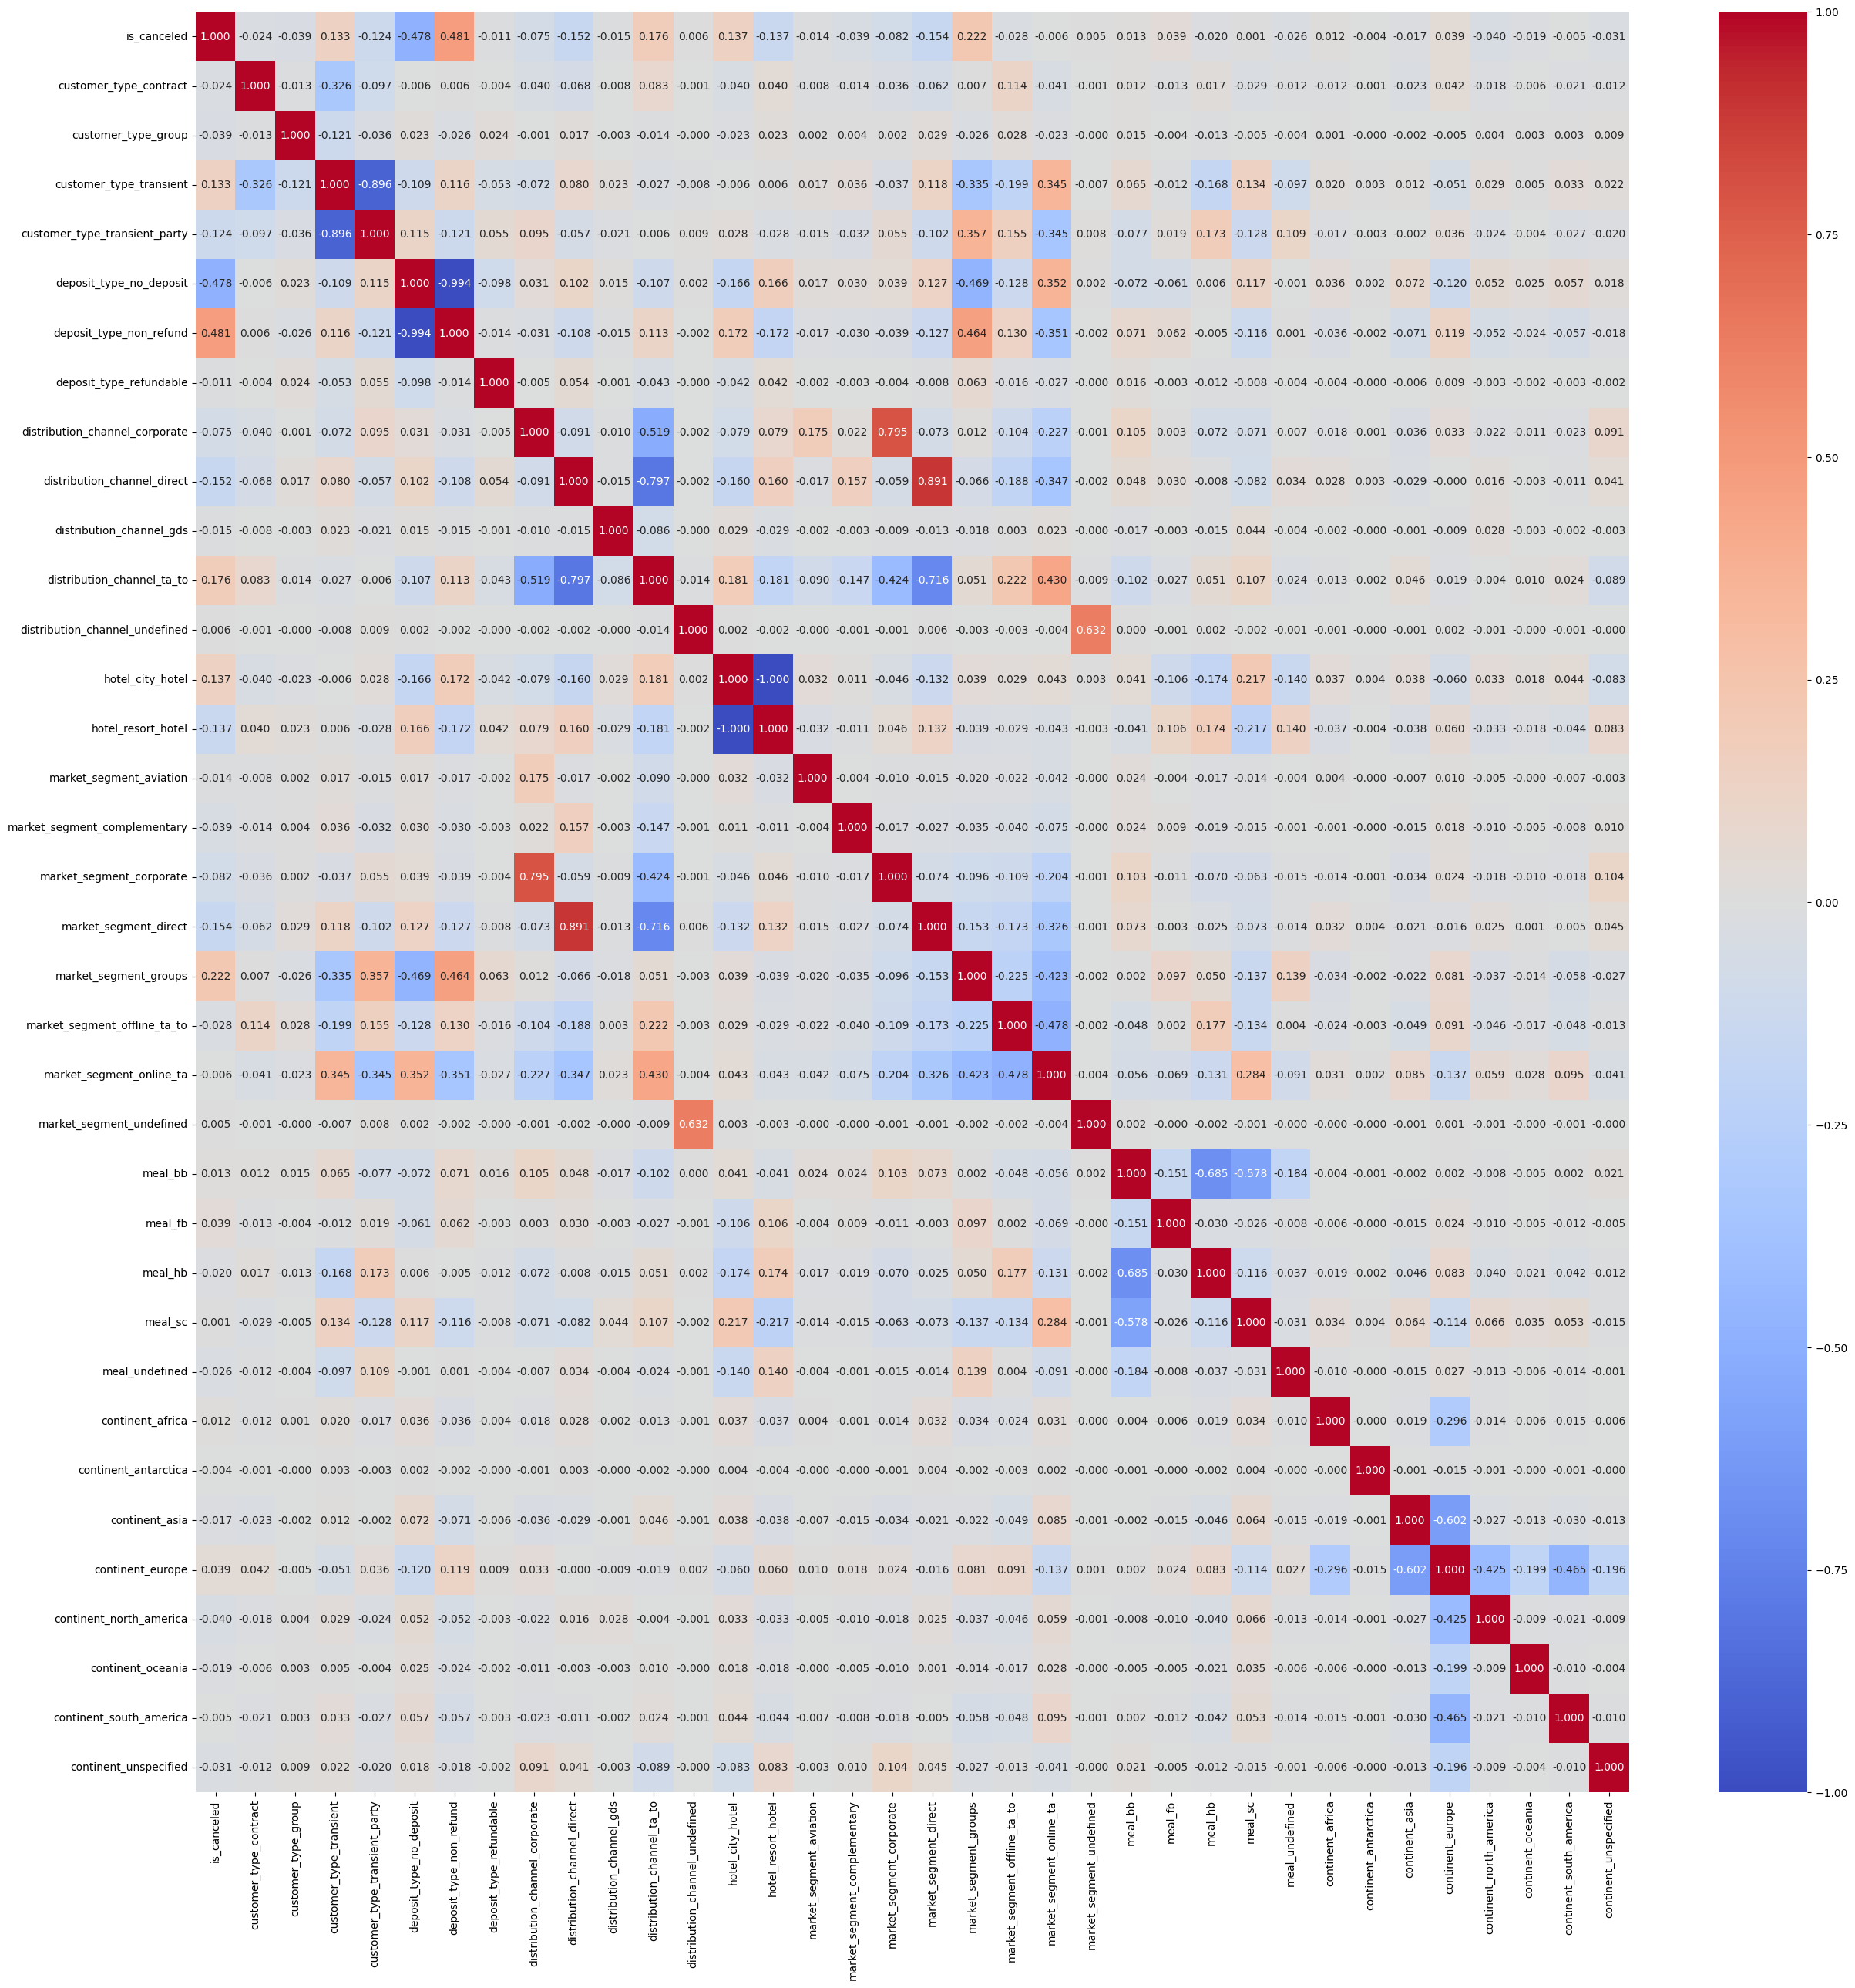

In [ ]:
plt.figure(figsize=(30, 30))
df_remain = pd.concat([df['is_canceled'], df[cols_to_drop]], axis=1)
hm = sns.heatmap(df_remain.corr(), annot=True, cmap='coolwarm', fmt='.3f')

# Data processing (submitted)

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/data/'
df = pd.read_csv(path + 'hotel_bookings.csv')
print(f'Original dataset shape: {df.shape}')

# Data processing
df['agent'] = df['agent'].notna().astype(int)
df['arrival_date_month'] = pd.to_datetime(
    df['arrival_date_month'], format='%B').dt.month
df['children'] = df['children'].fillna(0)
df['company'] = df['company'].notna().astype(int)
df['country'] = df['country'].fillna('Unknown')
# TODO (Chad): Map countries to continents

# Determine if customer got their desired room type
mask_equal = df['assigned_room_type'] == df['reserved_room_type']
mask_not_ik = ~df['assigned_room_type'].isin(['I', 'K'])
df['is_reserved_room_type'] = (mask_equal & mask_not_ik).astype(int)

# One-hot encode categorical columns
df = pd.get_dummies(df,
                    columns=['customer_type',
                             'deposit_type',
                             'distribution_channel',
                             'hotel',
                             'market_segment',
                             'meal', ],
                    dtype = int)

df = df.drop(['arrival_date_month',
              'assigned_room_type',
              'arrival_date_day_of_month',
              'arrival_date_week_number',
              'arrival_date_year',
              'reservation_status',
              'reservation_status_date',
              'reserved_room_type'], axis=1)

df.columns = df.columns.str.replace(r"[ _/\-]", '_', regex=True).str.lower()

print(f'Processed dataset shape: {df.shape}')
df.to_csv(path + 'hotel_bookings_processed.csv')

In [ ]:
print(df['booking_changes'].unique())

In [ ]:
for feature in df.columns:
  if df[feature].dtype == 'O':
    print(feature)
    print(df[feature].unique())

# Data split

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234) # TODO: remove random_state
y = df['is_canceled']
X = df.drop('is_canceled', axis=1)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  X_train = X.iloc[train_index, :]
  X_test = X.iloc[test_index, :]
  y_train = y[train_index]
  y_test = y[test_index]

  # print(f"The shape of X_train is: {X_train.shape}")
  # print(f"The shape of X_test is: {X_test.shape}")
  # print(f"The shape of y_train is: {y_train.shape}")
  # print(f"The shape of y_test is: {y_test.shape}")

  train_data = pd.concat([X_train, y_train], axis=1)
  test_data = pd.concat([X_test, y_test], axis=1)

  train_data.to_csv('training_data' + str(i) + '.csv')
  test_data.to_csv('testing_data' + str(i) + '.csv')